<a href="https://colab.research.google.com/github/wangyeye66/projects/blob/main/customer_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Cleaning

In [43]:
data = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', sep ='\t')
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [44]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)

# Date of Last Purchase
d1 = data["Dt_Customer"].max()

# Calculate days as a customer until the most recent date
data['Customer_For'] = (d1 - data["Dt_Customer"]).dt.days

In [45]:
# Calculate Age
data["Age"] = 2021-data["Year_Birth"]

# Calculate Total Spend
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

# Marital Status
data["Marriage"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

# Calculate Number of Children
data["Children"] =data["Kidhome"]+data["Teenhome"]

# Family Size
data["Family_Size"] = data["Marriage"].replace({"Alone": 1, "Partner":2})+ data["Children"]

# Coupon Usage
data['Coupon'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] +data['AcceptedCmp4'] +data['AcceptedCmp5'] + data["Response"]

In [46]:
# Drop Columns
drop_lst = ['Dt_Customer', 'Year_Birth','ID', "Dt_Customer", "Z_CostContact", "Z_Revenue","MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds","Marital_Status","Kidhome","Teenhome",'AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain']
data = data.drop(drop_lst, axis =1)
data.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Marriage,Children,Family_Size,Coupon
0,Graduation,58138.0,58,3,8,10,4,7,663,64,1617,Alone,0,1,1
1,Graduation,46344.0,38,2,1,1,2,5,113,67,27,Alone,2,3,0
2,Graduation,71613.0,26,1,8,2,10,4,312,56,776,Partner,0,2,0
3,Graduation,26646.0,26,2,2,0,4,6,139,37,53,Partner,1,3,0
4,PhD,58293.0,94,5,5,3,6,5,161,40,422,Partner,1,3,0


In [47]:
#drop outlier
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]

In [48]:
# Feature
cat_feature = data.select_dtypes(include=['object']).columns.tolist()
num_feature = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
len(cat_feature), len(num_feature)

(2, 13)

In [49]:
print('Missing Values Before: ', data.isna().sum().sum())

# Handle Missing Values
for i in cat_feature:
  data[i].fillna(data[i].mode()[0], inplace=True)

for i in num_feature:
  data[i].fillna(data[i].median(), inplace=True)

print('Missing Values After: ', data.isna().sum().sum())

Missing Values Before:  0
Missing Values After:  0


In [50]:
# One Hot Encoding
encoder = OneHotEncoder()
onehot = encoder.fit_transform(data[cat_feature])

cat_feature_name = encoder.get_feature_names_out(cat_feature)
print(cat_feature_name)

['Education_2n Cycle' 'Education_Basic' 'Education_Graduation'
 'Education_Master' 'Education_PhD' 'Marriage_Alone' 'Marriage_Partner']


In [51]:
onehot = onehot.toarray()
onehot.shape

(2212, 7)

In [52]:
# Standardization
standard = StandardScaler()
num_stad = standard.fit_transform(data[num_feature])

In [53]:
all_feature_names = num_feature + list(cat_feature_name)
all_feature_names

['Income',
 'Recency',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Customer_For',
 'Age',
 'Spent',
 'Children',
 'Family_Size',
 'Coupon',
 'Education_2n Cycle',
 'Education_Basic',
 'Education_Graduation',
 'Education_Master',
 'Education_PhD',
 'Marriage_Alone',
 'Marriage_Partner']

In [54]:
df_pre = np.([num_stad, onehot], axis=1)
df_pre= pd.DataFrame(df_pre, columns = all_feature_names)
df = df_pre.copy()

In [55]:
df.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Coupon,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marriage_Alone,Marriage_Partner
0,0.287105,0.310353,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.264598,-1.758359,0.617244,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.260882,-0.380813,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.404572,0.449070,-0.502808,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.913196,-0.795514,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,-1.264598,-0.654644,-0.502808,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.176114,-0.795514,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.069987,0.449070,-0.502808,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.294307,1.554453,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.069987,0.449070,-0.502808,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### PCA

In [56]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

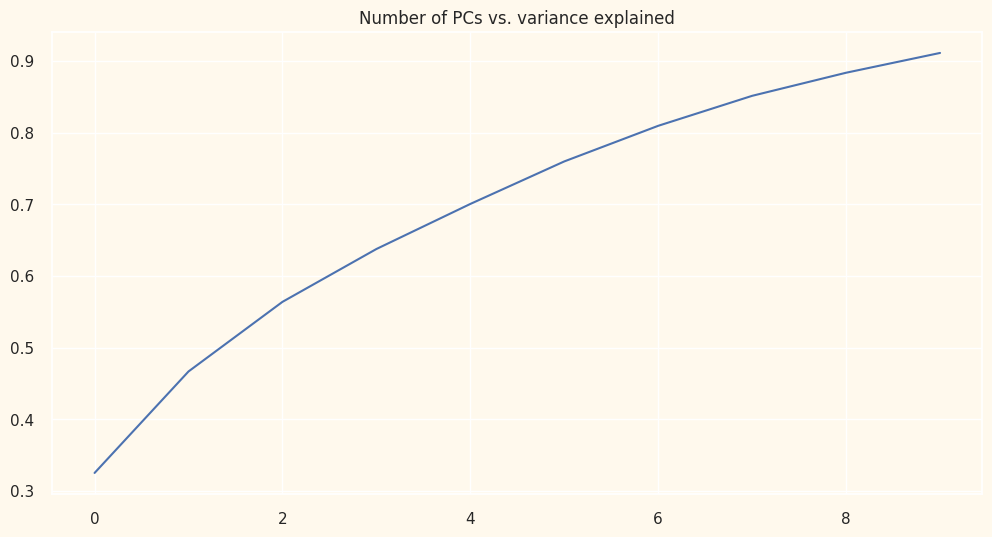

In [57]:
pca= PCA(n_components=10)
columns_pca = [f'PC{i+1}' for i in range(10)]
pca.fit(df)
pca_df = pd.DataFrame(pca.transform(df), columns = columns_pca)


plt.figure(figsize =(12,6))
plt.title('Number of PCs vs. variance explained')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [58]:
# 2212 * 10
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,2.868764,0.707299,2.172262,-0.665383,-1.322768,1.028345,0.231536,0.736864,1.232963,1.513878
1,-1.938697,-0.518669,-1.701208,0.502325,-0.974174,0.621172,0.503496,0.932333,-0.547142,0.617911
2,1.893167,-0.174855,-0.197617,0.318385,-0.822912,-1.260778,-0.057684,-1.515575,-0.001371,-0.160910
3,-2.040988,-1.192269,-0.108759,0.794477,0.810931,-0.954866,0.178214,-0.314989,0.372993,-0.259980
4,-0.334117,0.678951,-0.608099,-1.283856,1.452693,-0.597473,1.088800,0.142604,0.740582,-0.238111


In [59]:
components = pd.DataFrame(pca.components_, columns=all_feature_names)
#10*20
components

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Coupon,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marriage_Alone,Marriage_Partner
0,0.396123,-0.000633,-0.099768,0.241355,0.383254,0.339201,-0.312640,0.028377,0.067166,0.424569,-0.315351,-0.287014,0.215384,-0.005443,-0.009937,0.004809,-0.000719,0.011291,0.023752,-0.023752
1,0.125576,0.023247,0.534397,0.395145,0.106023,0.223020,0.195852,0.276138,0.224193,0.136262,0.368000,0.386984,0.012302,-0.010459,-0.014934,-0.005955,0.007097,0.024251,-0.074879,0.074879
2,-0.231820,-0.081331,0.118331,0.141570,-0.030397,-0.059481,0.432377,0.569366,-0.372885,0.044138,-0.251082,-0.330980,0.220965,0.013739,0.019628,0.022041,-0.023454,-0.031953,0.111743,-0.111743
3,0.040461,-0.889620,-0.007638,0.000397,-0.014444,-0.067874,0.022380,-0.177116,-0.019494,0.004005,0.084247,0.109813,0.382619,-0.001603,-0.004414,-0.030003,0.014209,0.021811,-0.036368,0.036368
4,0.113030,0.244167,0.041919,-0.086890,0.119308,-0.018851,-0.088523,-0.155562,-0.766211,0.109091,0.141637,0.310201,0.303116,0.016521,-0.002202,0.039757,-0.024697,-0.029379,-0.174923,0.174923
5,0.006593,0.331240,-0.183270,-0.134471,0.042035,-0.344577,0.131371,0.067861,0.420458,0.045698,0.094188,0.067874,0.706856,-0.021477,-0.002775,-0.032138,0.006396,0.049993,0.009079,-0.009079
6,-0.058467,0.152166,0.334817,0.348946,-0.107543,-0.004914,0.169001,-0.648442,-0.064094,-0.061879,0.042331,-0.278609,0.170338,-0.006215,-0.007855,-0.015993,0.003217,0.026846,0.284147,-0.284147
7,0.047752,-0.058310,0.507172,-0.571090,0.351851,-0.148106,-0.246424,0.117040,-0.010624,0.012047,0.166911,-0.152550,-0.016112,-0.005419,0.000158,0.014682,0.005843,-0.015265,0.263281,-0.263281
8,-0.213222,-0.006504,0.321223,0.026610,0.396970,-0.343230,0.137311,-0.221851,0.123131,0.023775,-0.469357,0.008961,-0.105025,0.014367,0.016309,-0.019745,0.003475,-0.014405,-0.359807,0.359807
9,0.223469,-0.065123,-0.263800,0.388083,0.320777,-0.637241,0.005037,0.065988,-0.108509,0.053817,0.236003,0.020587,-0.274484,-0.026311,-0.012399,0.106965,-0.061280,-0.006976,0.158184,-0.158184


In [60]:
for k in range(2):
  print("Top contributing feature for PC" + str(k) + ":")
  print(components.iloc[k].sort_values(ascending=False)[0:10])
  print()

Top contributing feature for PC0:
Spent                  0.424569
Income                 0.396123
NumCatalogPurchases    0.383254
NumStorePurchases      0.339201
NumWebPurchases        0.241355
Coupon                 0.215384
Age                    0.067166
Customer_For           0.028377
Marriage_Alone         0.023752
Education_PhD          0.011291
Name: 0, dtype: float64

Top contributing feature for PC1:
NumDealsPurchases    0.534397
NumWebPurchases      0.395145
Family_Size          0.386984
Children             0.368000
Customer_For         0.276138
Age                  0.224193
NumStorePurchases    0.223020
NumWebVisitsMonth    0.195852
Spent                0.136262
Income               0.125576
Name: 1, dtype: float64



### K Means with PCA

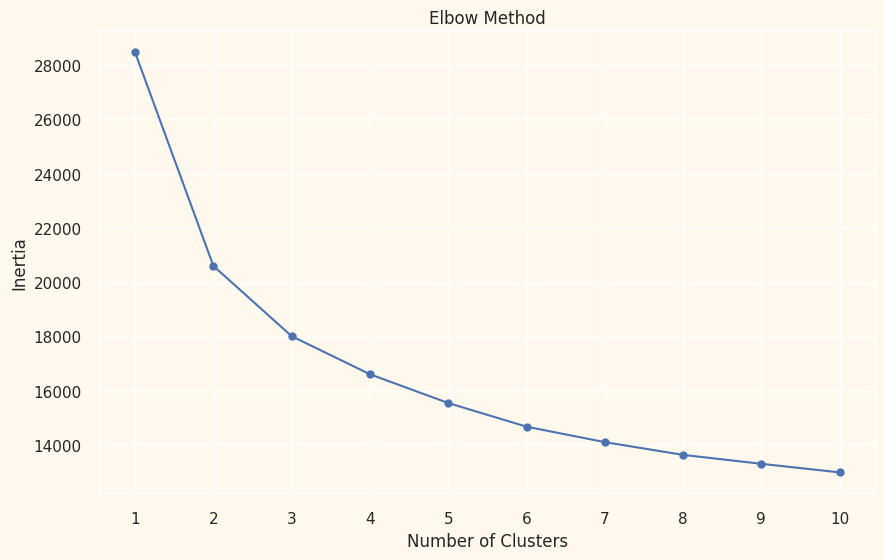

In [61]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

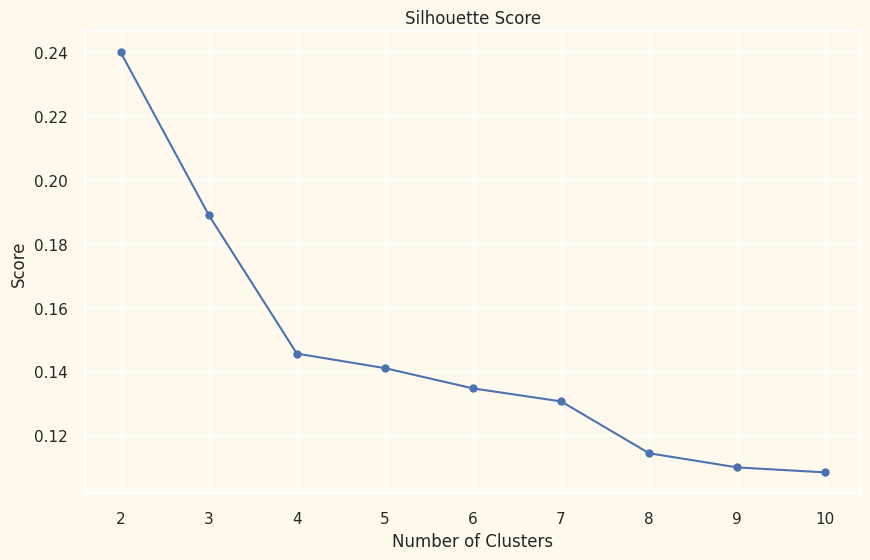

In [62]:
silhouette_scores = []

for k in k_range[1:]:  # Start from 2 clusters
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(pca_df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, '-o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(k_range[1:])
plt.show()

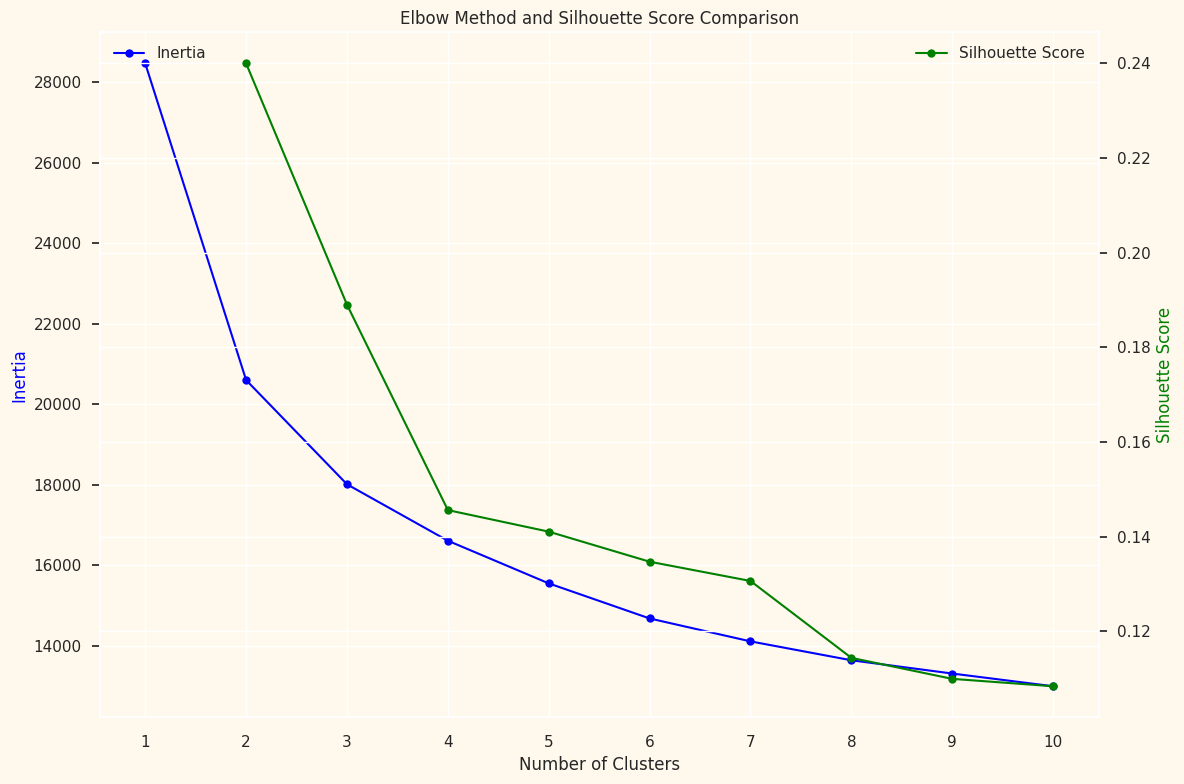

In [63]:
# plot them together

plt.figure(figsize=(12, 8))

plt.plot(k_range, inertia, '-o', label='Inertia', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia', color='blue')
plt.xticks(k_range)
plt.legend(loc='upper left')

ax2 = plt.twinx()
ax2.plot(k_range[1:], silhouette_scores, '-o', label='Silhouette Score', color='green')
ax2.set_ylabel('Silhouette Score', color='green')
ax2.legend(loc='upper right')

plt.title('Elbow Method and Silhouette Score Comparison')
plt.tight_layout()
plt.show()

In [64]:
# Choose k = 3
k_opt = 3
kmeans_final = KMeans(n_clusters=k_opt, n_init=1,random_state=42)
# fit model and predict clusters
yhat_kmeans = kmeans_final.fit_predict(pca_df)
# Centroids
centroids = kmeans_final.cluster_centers_
df["Clusters"] = yhat_kmeans
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_kmeans

# Calculate Distance
distance_2 = kmeans_final.inertia_
distance_2

18012.969884157013

In [65]:
cluster_means = data.groupby('Clusters').mean(numeric_only=True)
cluster_means

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Coupon
Clusters,,,,,,,,,,,,,
0,57537.106583,48.626959,4.003135,6.426332,3.073668,7.725705,5.929467,431.617555,55.653605,749.578370,1.242947,2.960815,0.338558
1,34409.437437,49.104104,1.931932,2.038038,0.536537,3.191191,6.412412,312.902903,49.318318,93.529530,1.216216,2.856857,0.173173
2,76259.455652,49.307826,1.144348,5.055652,5.937391,8.220870,2.751304,338.180870,52.937391,1341.930435,0.153043,1.726957,1.050435


- Group 0:mid income, buy deal products most, group 0&1 have similar children and family size
- Group 1: low income, mostly online purchase, spend least,
- Group 2: highest income, mostly instore purchase, spend most, least children and smallest family size, use coupon most


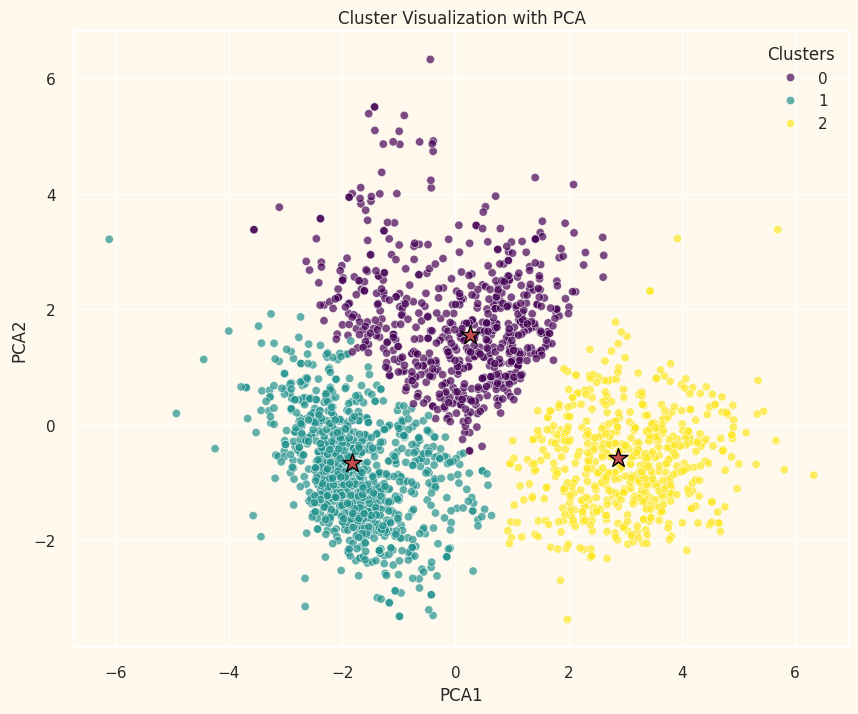

In [66]:
pca_final = PCA(n_components=2)
df_pca_final = pca_final.fit_transform(df)

df['PCA1'] = df_pca_final[:, 0]
df['PCA2'] = df_pca_final[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Clusters', palette='viridis', alpha=0.7)
for i in range(len(centroids)):
  plt.scatter(centroids[i, 0], centroids[i, 1], s =200, c = 'r', edgecolor='black', marker='*', label=f'Centroid {i}')
plt.title('Cluster Visualization with PCA')
plt.show()

In [67]:
# 3d -> Choose three PCs
drop_lst = ['Clusters', 'PCA1', 'PCA2']
df = df.drop(drop_lst, axis =1)

pca2 = PCA(n_components=3)
pca2.fit(df)
PCA_ds = pd.DataFrame(pca2.transform(df), columns=(["PCA1","PCA2", "PCA3"]))

In [68]:
kmeans_ds = KMeans(n_clusters=k_opt, n_init=1,random_state=42)
# fit model and predict clusters
yhat_kmeans = kmeans_ds.fit_predict(PCA_ds)
df["Clusters"] = yhat_kmeans

distance_3 = kmeans_ds.inertia_
distance_3

7276.757171794019

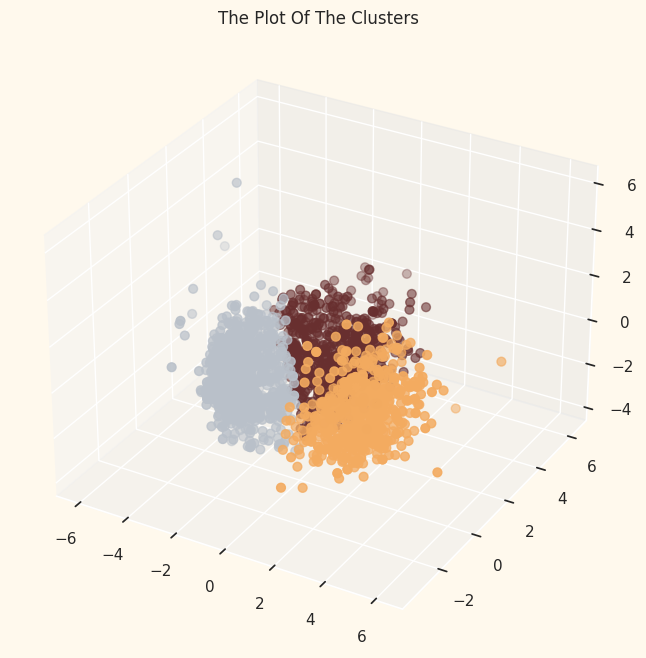

In [69]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["PCA1"]
y =PCA_ds["PCA2"]
z =PCA_ds["PCA3"]

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=df["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

In [70]:
print(f'The interia of two Priciple Components is {distance_2}\nThe interia of three Priciple Components is {distance_3}')

The interia of two Priciple Components is 18012.969884157013
The interia of three Priciple Components is 7276.757171794019


More PCs leads to a smaller interia.

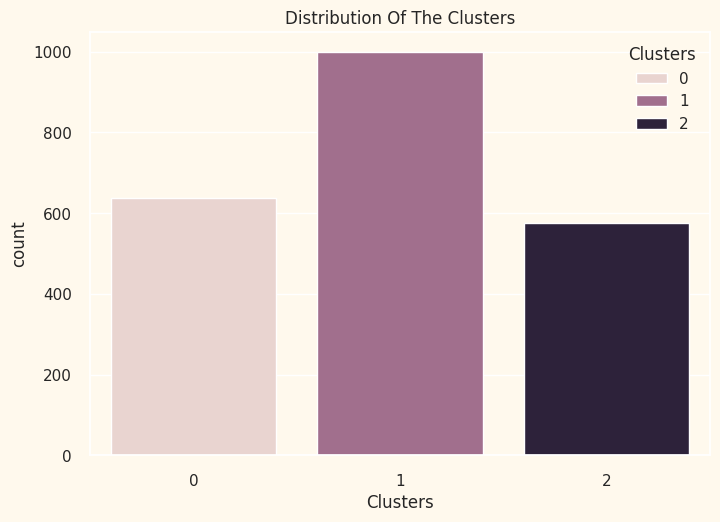

In [71]:
pl = sns.countplot(x=data["Clusters"], hue=data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

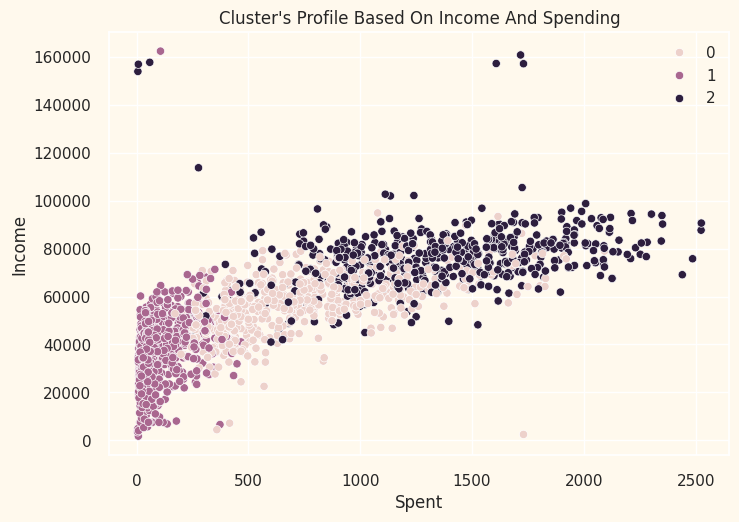

In [72]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income < 60000, more likely to spend less.
Income > 60000, spend more


### kmeans with AutoEncoder


In [98]:
%%capture
!pip install tensorflow

Epoch 1/50
7/7 [==============================] - 3s 89ms/step - loss: 0.7481 - val_loss: 0.7499
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.7327 - val_loss: 0.7331
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.7085 - val_loss: 0.7012
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.6687 - val_loss: 0.6566
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.6217 - val_loss: 0.6138
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.5818 - val_loss: 0.5781
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.5478 - val_loss: 0.5495
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.5214 - val_loss: 0.5282
Epoch 9/50
7/7 [==============================] - 0s 16ms/step - loss: 0.4999 - val_loss: 0.5083
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.4793 - val_loss: 0.4871
Epoch 11/50
7/7 [============

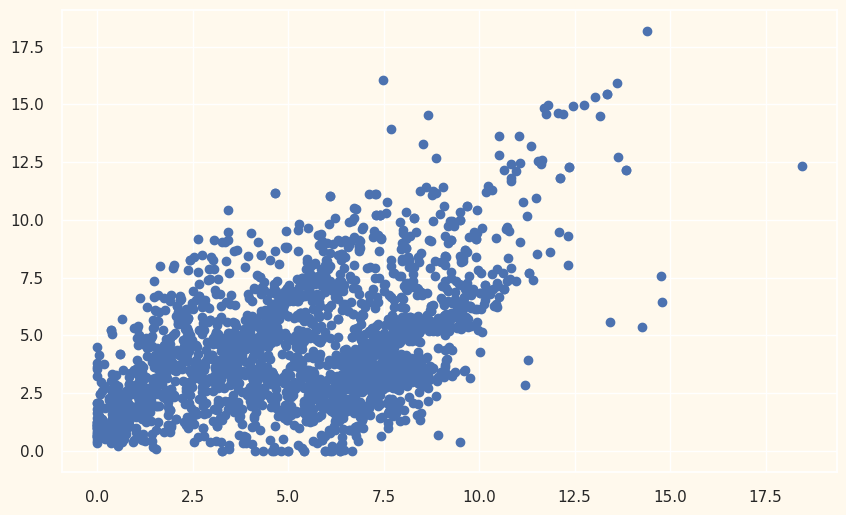

In [78]:
import tensorflow as tf # AutoEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

df_processed = df_pre.copy()
input_dim = df_processed.shape[1]

encoding_dim = 2 # compressing to a 2D space
input_layer = Input(shape=(input_dim,)) # input layer

# Encoder layers
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation ='relu')(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
# Decoder layers
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# Model Training
autoencoder.fit(df_processed,df_processed,
                epochs = 50,
                batch_size=256,
                shuffle =True,
                validation_split = 0.2)

# Extracting the Encoded Representation
encoder_model = Model(inputs=input_layer, outputs=encoder)
# Use the encoder to generate the compressed representation of the data
encoded_data = encoder_model.predict(df_processed)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.show()

In [79]:
# now it transformed into 2D
encoded_data

array([[3.515436  , 6.738985  ],
       [6.4596643 , 4.037583  ],
       [2.0270705 , 2.4118013 ],
       ...,
       [0.61986023, 1.1529316 ],
       [3.3579133 , 3.863372  ],
       [9.267615  , 7.744695  ]], dtype=float32)

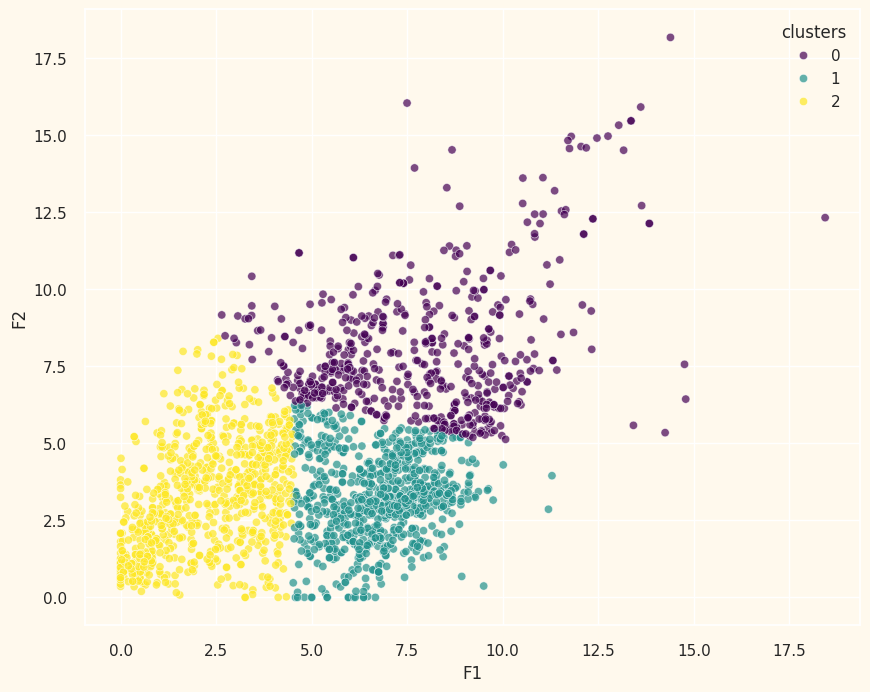

In [80]:
kmeans = KMeans(n_clusters=3, n_init=1, random_state=42)
kmeans.fit(encoded_data)
df_auto=pd.DataFrame(encoded_data, columns=['F1','F2'])
df_auto['clusters']=kmeans.labels_
# plotting clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_auto, x='F1', y='F2', hue='clusters', palette='viridis', alpha=0.7)
plt.show()

### kmeans with TSNE

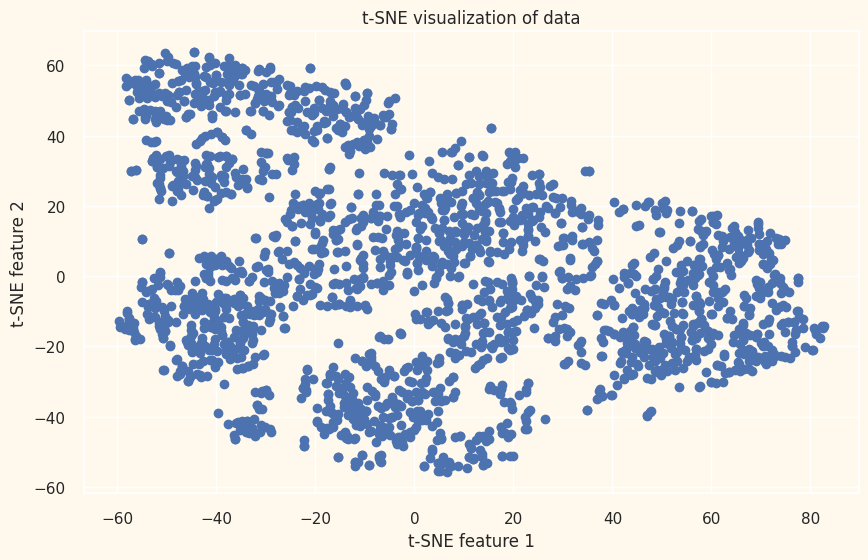

In [82]:
from sklearn.manifold import TSNE #TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state = 42)
tsne_results = tsne.fit_transform(df_processed)

# plot the result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


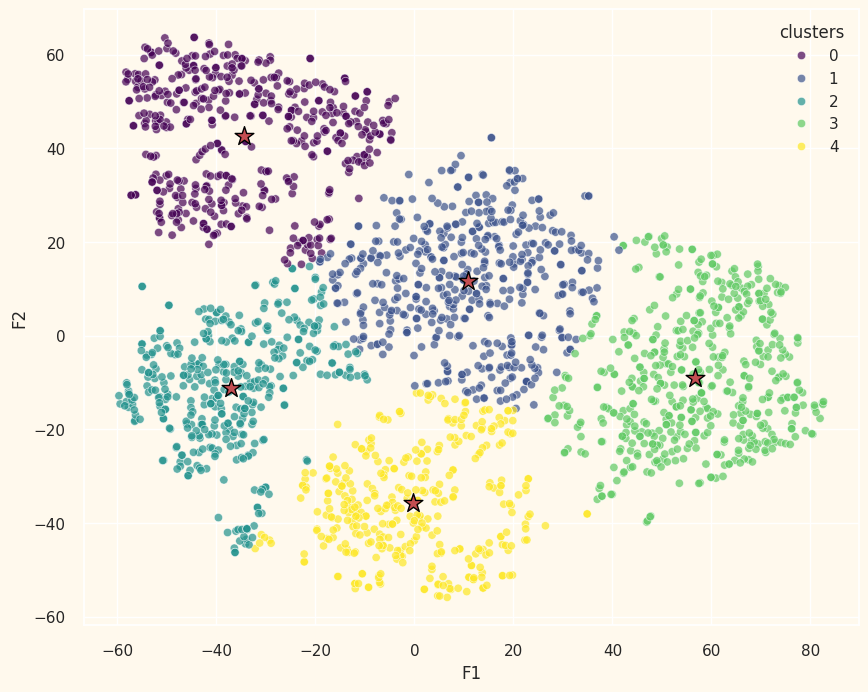

In [86]:
# 5 groups
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tsne_results)
df_tsne=pd.DataFrame(tsne_results, columns=['F1','F2'])
df_tsne['clusters']=kmeans.labels_
centroids = kmeans.cluster_centers_
# plotting clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='F1', y='F2', hue='clusters', palette='viridis', alpha=0.7)
for i in range(len(centroids)):
  plt.scatter(centroids[i, 0], centroids[i, 1], s =200, c = 'r', edgecolor='black', marker='*', label=f'Centroid {i}')
plt.show()

In [95]:
data['Clusters'] = kmeans.labels_
cluster_means_tsne = data.groupby('Clusters').mean(numeric_only=True)
cluster_means_tsne

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Coupon
Clusters,,,,,,,,,,,,,
0,42468.863341,49.945770,3.791757,3.164859,0.969631,4.010846,6.555315,349.130152,54.613883,215.490239,2.036876,3.711497,0.219089
1,62669.752083,49.183333,3.108333,6.516667,3.937500,8.414583,5.129167,395.266667,55.975000,883.220833,1.047917,2.806250,0.304167
2,32346.547074,49.027990,1.709924,2.132316,0.526718,3.162850,6.646310,322.038168,45.358779,97.580153,0.931298,2.926209,0.198473
3,76453.001938,50.488372,1.062016,4.844961,5.804264,8.110465,2.674419,341.498062,52.930233,1363.308140,0.065891,1.662791,1.131783
4,36219.116022,45.519337,1.883978,3.088398,1.027624,4.220994,6.339779,356.256906,49.812155,215.950276,0.701657,1.850829,0.232044


### kmeans with UMAP

In [97]:
%%capture
! pip install umap-learn

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


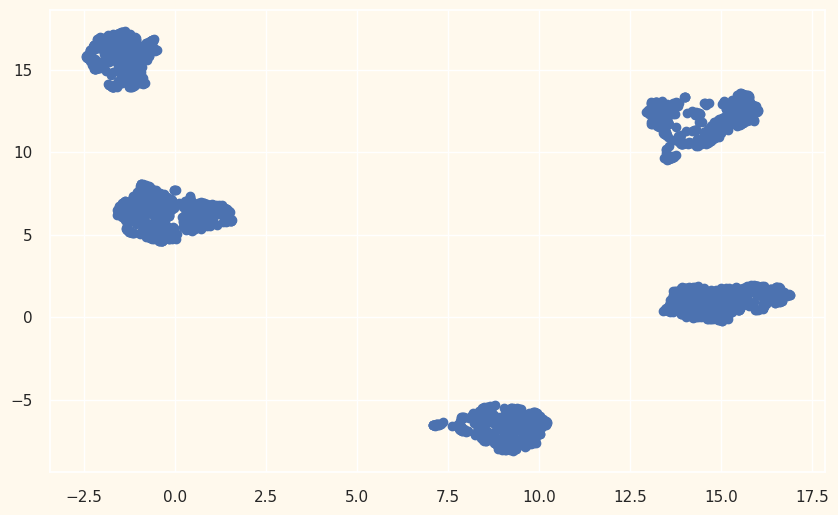

In [99]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(df_processed)
# Convert the embedding result into a DataFrame for easier plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
# Plotting the results of UMAP
plt.figure(figsize=(10, 6))
plt.scatter(embedding_df['UMAP-1'], embedding_df['UMAP-2'])
plt.show()

In [100]:
embedding_df

,UMAP-1,UMAP-2
0,0.434338,5.965159
1,13.620424,12.850859
2,-1.043104,6.834695
3,8.429252,-6.885088
4,14.344363,1.106214
...,...,...
2207,15.083965,1.077687
2208,14.355906,10.716209
2209,1.394296,6.488252
2210,14.101737,0.410155


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


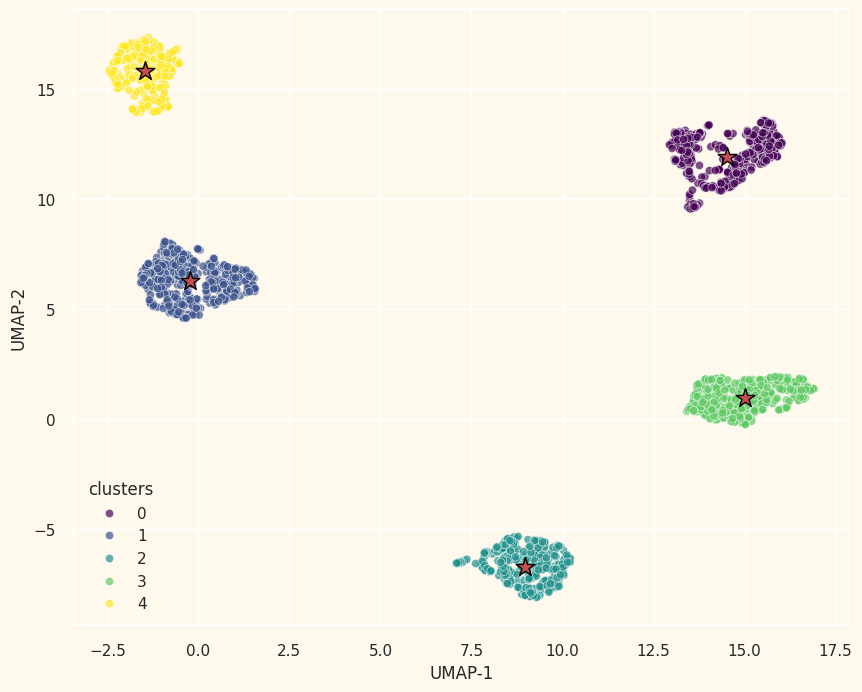

In [102]:
# 5 clusters

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(embedding_df)
embedding_df['clusters']=kmeans.labels_
centroids = kmeans.cluster_centers_

# plotting clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=embedding_df, x='UMAP-1', y='UMAP-2', hue='clusters', palette='viridis', alpha=0.7)
for i in range(len(centroids)):
  plt.scatter(centroids[i, 0], centroids[i, 1], s =200, c = 'r', edgecolor='black', marker='*', label=f'Centroid {i}')
plt.show()

In [119]:
import numpy as np
def mode(x: pd.Series) -> str:
  return x.mode().iloc[0]

In [124]:
data['Clusters'] = kmeans.labels_
cluster_means_ump_category = data.groupby('Clusters').agg({
                                'Education': lambda x: mode(x),
                                'Marriage':lambda x: mode(x)})

cluster_means_ump_numeric = data.groupby('Clusters').mean(numeric_only=True)

In [125]:
pd.concat([cluster_means_ump_category, cluster_means_ump_numeric], axis=1)

,Education,Marriage,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Coupon
Clusters,,,,,,,,,,,,,,,
0,Graduation,Partner,42468.863341,49.945770,3.791757,3.164859,0.969631,4.010846,6.555315,349.130152,54.613883,215.490239,2.036876,3.711497,0.219089
1,Graduation,Partner,76453.001938,50.488372,1.062016,4.844961,5.804264,8.110465,2.674419,341.498062,52.930233,1363.308140,0.065891,1.662791,1.131783
2,Graduation,Partner,32273.415816,49.109694,1.704082,2.114796,0.520408,3.160714,6.645408,321.107143,45.369898,94.903061,0.931122,2.926020,0.198980
3,Graduation,Partner,62666.309771,49.116424,3.110187,6.521830,3.935551,8.405405,5.133056,395.873181,55.943867,883.769231,1.047817,2.806653,0.303534
4,Graduation,Alone,36219.116022,45.519337,1.883978,3.088398,1.027624,4.220994,6.339779,356.256906,49.812155,215.950276,0.701657,1.850829,0.232044
